# Regression

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

download('https://raw.githubusercontent.com/AllenDowney/ElementsOfDataScience/v1/utils.py')

import utils

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ElementsOfDataScience/blob/v1/10_regression.ipynb).

In the previous chapter we used simple linear regression to quantify the relationship between two variables.
In this chapter we'll get farther into regression, including multiple regression and one of my all-time favorite tools, logistic regression.
These tools will allow us to explore relationships among sets of variables.
As an example, we will use data from the General Social Survey (GSS) to explore the relationship between income, education, age, and sex.

The GSS dataset contains hundreds of columns.
We'll work with an extract that contains just the columns we need, as we did in Chapter 8.
Instructions for downloading the extract are in the notebook for this chapter.

In [2]:
download('https://github.com/AllenDowney/ElementsOfDataScience/' +
         'raw/v1/data/gss_extract_2022.hdf');

We can read the `DataFrame` like this and display the first few rows.

In [49]:
import pandas as pd

gss = pd.read_hdf('gss_extract_2022.hdf', 'gss')
gss.head()

year  id   age  educ  degree  sex  gunlaw  grass  realinc
0  1972   1  23.0  16.0     3.0  2.0     1.0    NaN  18951.0
1  1972   2  70.0  10.0     0.0  1.0     1.0    NaN  24366.0
2  1972   3  48.0  12.0     1.0  2.0     1.0    NaN  24366.0
3  1972   4  27.0  17.0     3.0  2.0     1.0    NaN  30458.0
4  1972   5  61.0  12.0     1.0  2.0     1.0    NaN  50763.0

We'll start with a simple regression, estimating the parameters of real income as a function of years of education.
First we'll select the subset of the data where both variables are valid.

In [5]:
data = gss.dropna(subset=['realinc', 'educ'])
xs = data['educ']
ys = data['realinc']

Now we can use `linregress` to fit a line to the data.

In [6]:
from scipy.stats import linregress
res = linregress(xs, ys)
res._asdict()

{'slope': 3631.0761003894995,
 'intercept': -15007.453640508655,
 'rvalue': 0.37169252259280877,
 'pvalue': 0.0,
 'stderr': 35.625290800764,
 'intercept_stderr': 480.07467595184363}

The estimated slope is about `3450`, which means that each additional year of education is associated with an additional $3450 of income.

## Regression with StatsModels

SciPy doesn't do multiple regression, so we'll to switch to a new library, StatsModels.  Here's the import statement.

In [7]:
import statsmodels.formula.api as smf

To fit a regression model, we'll use `ols`, which stands for "ordinary least squares", another name for regression.

In [8]:
results = smf.ols('realinc ~ educ', data=data).fit()

The first argument is a **formula string** that specifies that we want to regress income as a function of education.
The second argument is the `DataFrame` containing the subset of valid data.
The names in the formula string correspond to columns in the `DataFrame`.
The result from `ols` is an object that represents the model; it provides a function called `fit` that does the actual computation.

In [9]:
type(results)

statsmodels.regression.linear_model.RegressionResultsWrapper

The result is a `RegressionResultsWrapper`, which contains a `Series` called `params`, which contains the estimated intercept and the slope associated with `educ`.

In [10]:
results.params

Intercept   -15007.453641
educ          3631.076100
dtype: float64

The results from Statsmodels are the same as the results we got from SciPy, so that's good!

**Exercise:** Let's run another regression using SciPy and StatsModels, and confirm we get the same results.
Compute the regression of `realinc` as a function of `age` using SciPy's `linregress` and then using StatsModels' `smf.ols`.
Confirm that the intercept and slope are the same.
Remember to use `dropna` to select the rows with valid data in both columns.

In [11]:
# Solution

data = gss.dropna(subset=['realinc', 'age'])
xs = data['age']
ys = data['realinc']

res = linregress(xs, ys)
res._asdict()

{'slope': -35.777496403061036,
 'intercept': 34148.79417109003,
 'rvalue': -0.02000684524772686,
 'pvalue': 3.728019377398043e-07,
 'stderr': 7.038831749655493,
 'intercept_stderr': 346.12532772697745}

In [12]:
# Solution

results = smf.ols('realinc ~ age', data=data).fit()
results.params

Intercept    34148.794171
age            -35.777496
dtype: float64

## Multiple Regression

In the previous section, we saw that income depends on education, and in the exercise we saw that it also depends on `age`.
Now let's put them together in a single model.

In [13]:
results = smf.ols('realinc ~ educ + age', data=gss).fit()
results.params

Intercept   -17999.726908
educ          3665.108238
age             55.071802
dtype: float64

In this model, `realinc` is the variable we are trying to explain or predict, which is called the **dependent variable** because it depends on the the other variables -- or at least we expect it to.
The other variables, `educ` and `age`, are called **independent variables** or sometimes "predictors".
The `+` sign indicates that we expect the contributions of the independent variables to be additive.

The result contains an intercept and two slopes, which estimate the average contribution of each predictor with the other predictor held constant.

* The estimated slope for `educ` is about `3665` -- so if we compare two people with the same age, and one has an additional year of education, we expect their income to be higher by $3514.

* The estimated slope for `age` is about `55` -- so if we compare two people with the same education, and one is a year older, we expect their income to be higher by $55.

In this model, the contribution of age is quite small, but as we'll see in the next section that might be misleading.

## Grouping by Age

Let's look more closely at the relationship between income and age.
We'll use a Pandas method we have not seen before, called `groupby`, to divide the `DataFrame` into age groups.

In [14]:
grouped = gss.groupby('age')
type(grouped)

pandas.core.groupby.generic.DataFrameGroupBy

The result is a `GroupBy` object that contains one group for each value of `age`.
The `GroupBy` object behaves like a `DataFrame` in many ways.
You can use brackets to select a column, like `realinc` in this example, and then invoke a method like `mean`.

In [15]:
mean_income_by_age = grouped['realinc'].mean()

The result is a Pandas `Series` that contains the mean income for each age group, which we can plot like this.

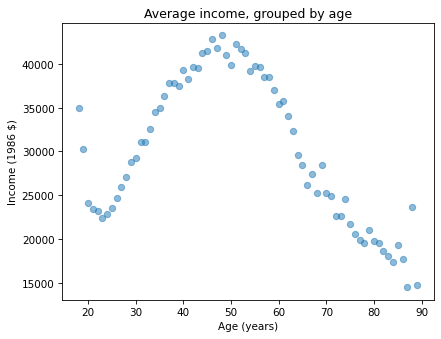

In [16]:
import matplotlib.pyplot as plt

plt.plot(mean_income_by_age, 'o', alpha=0.5)
plt.xlabel('Age (years)')
plt.ylabel('Income (1986 $)')
plt.title('Average income, grouped by age');

Average income increases from age 20 to age 50, then starts to fall.
And that explains why the estimated slope is so small, because the relationship is non-linear.

To describe a non-linear relationship, we'll create a new variable called `age2` that equals `age` squared.

In [17]:
gss['age2'] = gss['age']**2

Now we can run a regression with both `age` and `age2` on the right side.

In [18]:
model = smf.ols('realinc ~ educ + age + age2', data=gss)
results = model.fit()
results.params

Intercept   -52599.674844
educ          3464.870685
age           1779.196367
age2           -17.445272
dtype: float64

In this model, the slope associated with `age` is substantial, about $1779 per year.
The slope associated with `age2` is about -$17, but that's harder to interpret.
In the next section, we'll see methods to interpret multivariate models and visualize the results.
But first, here are two exercises where you can practice using `groupby` and `ols`.

**Exercise:** To get a closer look at the relationship between income and education, let's use the variable `educ` to group the data, then plot mean income in each group.

- Group `gss` by `educ`.

- From the resulting `GroupBy` object, extract `realinc` and compute the mean.

- Plot mean income in each education group.

What can you say about the relationship between education and income?
Does it look like a linear relationship?

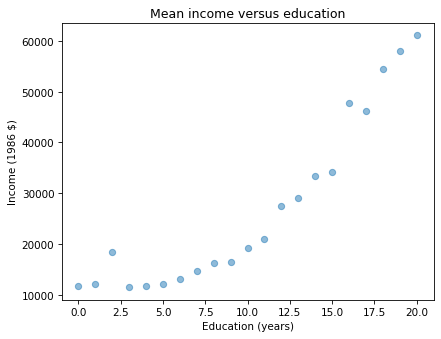

In [19]:
# Solution

grouped = gss.groupby('educ')

mean_income_by_educ = grouped['realinc'].mean()

plt.plot(mean_income_by_educ, 'o', alpha=0.5)

plt.xlabel('Education (years)')
plt.ylabel('Income (1986 $)')
plt.title('Mean income versus education');

**Exercise:** The graph in the previous exercise suggests that the relationship between income and education is non-linear.  So let's try fitting a non-linear model.

- Add a column named `educ2` to the `gss` DataFrame -- it should contain the values from `educ` squared.  

- Run a regression that uses `educ`, `educ2`, `age`, and `age2` to predict `realinc`.


In [20]:
# Solution

gss['educ2'] = gss['educ']**2

results = smf.ols('realinc ~ educ + educ2 + age + age2', 
                  data=gss).fit()

results.params

Intercept   -26336.766346
educ          -706.074107
educ2          165.962552
age           1728.454811
age2           -17.207513
dtype: float64

## Visualizing regression results

In the previous section we ran a multiple regression model to characterize the relationships between income, age, and education.
Because the model includes quadratic terms, the parameters are hard to interpret.
For example, you might notice that the parameter for `educ` is negative, and that might be a surprise, because it suggests that higher education is associated with lower income.
But the parameter for `educ2` is positive, and that makes a big difference.
In this section we'll see a way to interpret the model visually and validate it against data.

Here's the model from the previous exercise.

In [21]:
gss['educ2'] = gss['educ']**2

model = smf.ols('realinc ~ educ + educ2 + age + age2', data=gss)
results = model.fit()
results.params

Intercept   -26336.766346
educ          -706.074107
educ2          165.962552
age           1728.454811
age2           -17.207513
dtype: float64

The `results` object provides a method called `predict` that uses the estimated parameters to generate predictions.
It takes a `DataFrame` as a parameter and returns a `Series` with a prediction for each row in the `DataFrame`.
To use it, we'll create a new `DataFrame` with `age` running from 18 to 89, and `age2` set to `age` squared.

In [22]:
import numpy as np

df = pd.DataFrame()
df['age'] = np.linspace(18, 89)
df['age2'] = df['age']**2

Next, we'll pick a level for `educ`, like 12 years, which is the most common value.
When you assign a single value to a column in a `DataFrame`, Pandas makes a copy for each row.

In [23]:
df['educ'] = 12
df['educ2'] = df['educ']**2

Then we can use `results` to predict the average income for each age group, holding education constant.

In [24]:
pred12 = results.predict(df)

The result from `predict` is a `Series` with one prediction for each row.
So we can plot it with age on the $x$-axis and the predicted income for each age group on the $y$-axis.
And we'll plot the data for comparison.

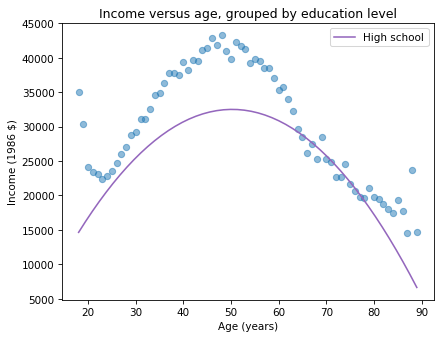

In [25]:
plt.plot(mean_income_by_age, 'o', alpha=0.5)

plt.plot(df['age'], pred12, label='High school', color='C4')

plt.xlabel('Age (years)')
plt.ylabel('Income (1986 $)')
plt.title('Income versus age, grouped by education level')
plt.legend();

The dots show the average income in each age group.
The line shows the predictions generated by the model, holding education constant.
This plot shows the shape of the model, a downward-facing parabola.

We can do the same thing with other levels of education, like 14 years, which is the nominal time to earn an Associate's degree, and 16 years, which is the nominal time to earn a Bachelor's degree.

In [26]:
df['educ'] = 16
df['educ2'] = df['educ']**2
pred16 = results.predict(df)

df['educ'] = 14
df['educ2'] = df['educ']**2
pred14 = results.predict(df)

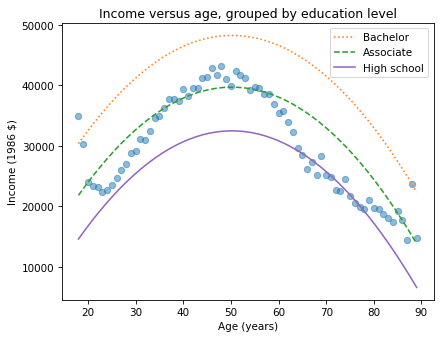

In [27]:
plt.plot(mean_income_by_age, 'o', alpha=0.5)

plt.plot(df['age'], pred16, ':', label='Bachelor')
plt.plot(df['age'], pred14, '--', label='Associate')
plt.plot(df['age'], pred12, label='High school', color='C4')

plt.xlabel('Age (years)')
plt.ylabel('Income (1986 $)')
plt.title('Income versus age, grouped by education level')
plt.legend();

The lines show expected income as a function of age for three levels of education.
This visualization helps validate the model, since we can compare the predictions with the data.
And it helps us interpret the model since we can see the separate contributions of age and education.

Sometimes we can understand a model by looking at its parameters, but often it is better to look at its predictions.
In the exercises, you'll have a chance to run a multiple regression, generate predictions, and visualize the results.

**Exercise:** At this point, we have a model that predicts income using age, education, and sex.

Let's see what it predicts for different levels of education, holding `age` constant.

- Create an empty `DataFrame` named `df`.

- Using `np.linspace()`, add a column named `educ` to `df` with a range of values from `0` to `20`.

- Add a column named `educ2` with the values from `educ` squared.

- Add a column named `age` with the constant value `30`.

- Add a column named `age2` with the values from `age` squared.

- Use the `results` object and `df` to generate expected income as a function of education.

In [28]:
# Solution

df = pd.DataFrame()
df['educ'] = np.linspace(0, 20)
df['age'] = 30
df['educ2'] = df['educ']**2
df['age2'] = df['age']**2

pred = results.predict(df)
pred.head()

0    10030.116309
1     9769.571701
2     9564.324903
3     9414.375915
4     9319.724737
dtype: float64

**Exercise:** Now let's visualize the results from the previous exercise.

- Group the GSS data by `educ` and compute the mean income in each education group.

- Plot mean income for each education group as a scatter plot.

- Plot the predictions from the previous exercise.

How do the predictions compare with the data?

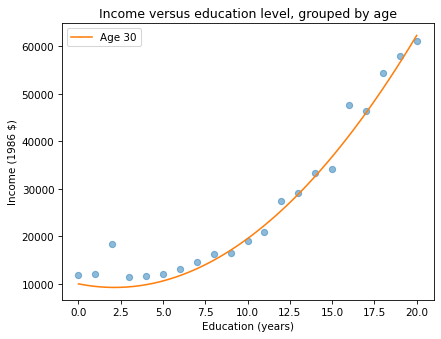

In [29]:
# Solution

grouped = gss.groupby('educ')
mean_income_by_educ = grouped['realinc'].mean()
plt.plot(mean_income_by_educ, 'o', alpha=0.5)

pred = results.predict(df)
plt.plot(df['educ'], pred, label='Age 30')

plt.xlabel('Education (years)')
plt.ylabel('Income (1986 $)')
plt.title('Income versus education level, grouped by age')
plt.legend();

## Categorical Variables

Most of the variables we have used so far -- like income, age, and education -- are numerical.
But variables like sex and race are **categorical** -- that is, each respondent belongs to one of a specified set of categories.
If there are only two categories, the variable is **binary**.

With StatsModels, it is easy to include a categorical variable as part of a regression model.
Here's an example:

In [30]:
formula = 'realinc ~ educ + educ2 + age + age2 + C(sex)'
results = smf.ols(formula, data=gss).fit()
results.params

Intercept       -24635.767539
C(sex)[T.2.0]    -4891.439306
educ              -496.623120
educ2              156.898221
age               1720.274097
age2               -17.097853
dtype: float64

In the formula string, the letter `C` indicates that `sex` is a categorical variable.
The regression treats the value `sex=1`, which is male, as the reference group, and reports the difference associated with the value `sex=2`, which is female.
So the results indicate that income for women is about $4156 less than for men, after controlling for age and education.
However, note that `realinc` represents household income.
If the respondent is married, it includes both their own income and their spouse's.
So we cannot interpret this result as an estimate of a gender gap in income.

## Logistic Regression

In the previous section, we added a categorical variables on the right side of a regression formula -- that is, we used it as a predictive variable.

But what if the categorical variable is on the left side of the regression formula -- that is, it's the value we are trying to predict?
In that case, we can use **logistic regression**.

As an example, one of the GSS questions asks "Would you favor or oppose a law which would require a person to obtain a police permit before he or she could buy a gun?"
The responses are in a column called `gunlaw` -- here are the values.  

In [31]:
gss['gunlaw'].value_counts()

gunlaw
1.0    36367
2.0    11940
Name: count, dtype: int64

`1` means yes and `2` means no, so most respondents are in favor.
To explore the relationship between this variable and factors like age, sex, and education, we can use StatsModels, which provides a function that does logistic regression.
To use it, we have to recode the dependent variable so `1` means "yes" and `0` means "no".
We can do that by replacing `2` with `0`.

In [32]:
gss['gunlaw'].replace([2], [0], inplace=True)

And we can check the results.

In [33]:
gss['gunlaw'].value_counts()

gunlaw
1.0    36367
0.0    11940
Name: count, dtype: int64

Now we can run the regression.
Instead of `ols()`, we'll use `logit()`, which is named for the logit function, which is related to logistic regression.

In [34]:
formula = 'gunlaw ~ age + age2 + educ + educ2 + C(sex)'
results = smf.logit(formula, data=gss).fit()

Optimization terminated successfully.
         Current function value: 0.544026
         Iterations 5


Estimating the parameters for the logistic model is an iterative process, so the output contains information about the number of iterations.
Other than that, everything is the same as what we have seen before.
Here are the estimated parameters.

In [35]:
results.params

Intercept        1.483746
C(sex)[T.2.0]    0.740717
age             -0.021274
age2             0.000216
educ            -0.098093
educ2            0.005557
dtype: float64

The parameters are in the form of **log odds** -- I won't explain them in detail here, except to say that positive values make the outcome more likely and negative values make the outcome less likely.
For example, the parameter associated with `sex=2` is `0.74`, which indicates that women are more likely to support this form of gun control.

To see how much more likely, we can generate predictions, as we did with linear regression.
As an example, we'll generate predictions for different ages and sexes, with education held constant.
First we need a `DataFrame` with a range of values for `age` and a fixed value of `educ`.

In [36]:
df = pd.DataFrame()
df['age'] = np.linspace(18, 89)
df['educ'] = 12

Then we can compute `age2` and `educ2`.

In [37]:
df['age2'] = df['age']**2
df['educ2'] = df['educ']**2

We can generate predictions for men like this.

In [38]:
df['sex'] = 1
pred_male = results.predict(df)

And for women like this.

In [39]:
df['sex'] = 2
pred_female = results.predict(df)

Now, to visualize the results, we'll start by plotting the data.
As we've done before, we'll divide the respondents into age groups and compute the mean in each group.
The mean of a binary variable is the fraction of people in favor.
Then we can plot the predictions.

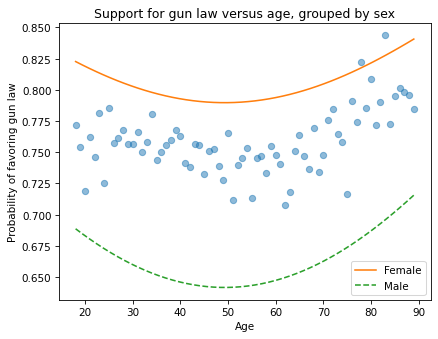

In [40]:
grouped = gss.groupby('age')
favor_by_age = grouped['gunlaw'].mean()
plt.plot(favor_by_age, 'o', alpha=0.5)

plt.plot(df['age'], pred_female, label='Female')
plt.plot(df['age'], pred_male, '--', label='Male')

plt.xlabel('Age')
plt.ylabel('Probability of favoring gun law')
plt.title('Support for gun law versus age, grouped by sex')
plt.legend();

According to the model, people near age 50 are least likely to support gun control (at least as this question was posed).
And women are more likely to support it than men, by about 15 percentage points.

Logistic regression is a powerful tool for exploring relationships between a binary variable and the factors that predict it.
In the exercises, you'll explore the factors that predict support for legalizing marijuana in the U.S.

**Exercise:** In the GSS dataset, the variable `grass` records the answer to the question "Do you think the use of marijuana should be made legal or not?"
Let's use logistic regression to explore relationships between these responses and age, sex, and education level.


1. First, use `replace` to recode the `grass` column so that `1` means yes and `0` means no.  Use `value_counts` to check.

2. Next, use `smf.logit()` to predict `grass` using the variables `age`, `age2`, `educ`, and `educ2`, along with `sex` as a categorical variable.  Display the parameters.  Are men or women more likely to support legalization?

3. To generate predictions, start with an empty DataFrame.  Add a column called `age` that contains a sequence of values from 18 to 89.  Add a column called `educ` and set it to 12 years.  Then compute a column, `age2`, which is the square of `age`, and a column, `educ2`, which is the square of `educ`. 

4. Use `predict` to generate predictions for men (`sex=1`) and women (`sex=2`).

5. Generate a plot that shows (a) the average level of support for legalizing marijuana in each age group, (b) the level of support the model predicts for men as a function of age, and (c) the level of support predicted for women as a function of age. 

In [41]:
# Solution

gss['grass'].replace(2, 0, inplace=True)
gss['grass'].value_counts()

grass
0.0    25997
1.0    12672
Name: count, dtype: int64

In [42]:
# Solution

results = smf.logit('grass ~ age + age2 + educ + educ2 + C(sex)', 
                    data=gss).fit()
results.params

Optimization terminated successfully.
         Current function value: 0.605895
         Iterations 6


Intercept       -1.971358
C(sex)[T.2.0]   -0.373592
age             -0.015406
age2             0.000004
educ             0.221171
educ2           -0.004209
dtype: float64

In [43]:
# Solution

df = pd.DataFrame()
df['age'] = np.linspace(18, 89)
df['age2'] = df['age']**2

df['educ'] = 12
df['educ2'] = df['educ']**2

In [44]:
# Solution

df['sex'] = 1
pred_male = results.predict(df)

df['sex'] = 2
pred_female = results.predict(df)

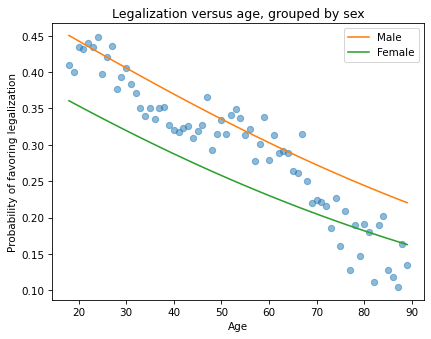

In [45]:
# Solution

grouped = gss.groupby('age')
favor_by_age = grouped['grass'].mean()
plt.plot(favor_by_age, 'o', alpha=0.5)

plt.plot(df['age'], pred_male, label='Male')
plt.plot(df['age'], pred_female, label='Female')

plt.xlabel('Age')
plt.ylabel('Probability of favoring legalization')
plt.title('Legalization versus age, grouped by sex')
plt.legend();

## Summary

At this point, I'd like to summarize the topics we've covered so far, and make some connections that might clarify the big picture.
A central theme of this book is **exploratory data analysis**, which is a process and set of tools for exploring a dataset, visualizing distributions, and discovering relationships between variables.
The last four chapters demonstrate the steps of this process:

- Chapter 7 is about importing and cleaning data, and checking for errors and other special conditions.  This might not be the most exciting part of the process, but time spent understanding data can save you from embarrassing errors.

- Chapter 8 is about exploring variables one at a time, visualizing distributions using PMFs, CDFs, and KDE, and choosing appropriate summary statistics.

- In Chapter 9 we explored relationships between variables two at a time, using scatter plots and other visualizations; and we quantified those relationships using correlation and simple regression.

- Finally, in this chapter, we explored multivariate relationships using multiple regression and logistic regression.

We moved through a lot of material quickly, but if you practice and apply these methods to other questions and other datasets, you will learn more as you go.
In the next chapter, we will move on to a new topic, resampling, which is a versatile tool for statistical inference.

Having finished this chapter, you might appreciate [this xkcd cartoon](https://xkcd.com/2048/).

<img src="https://imgs.xkcd.com/comics/curve_fitting_2x.png" width="400">

*Elements of Data Science*

Copyright 2021 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)